# Start with a simple Hidden Markov Model

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import HMM
from ssm.util import find_permutation

In [2]:
# Set the parameters of the HMM
T = 10000   # number of time bins
K = 5       # number of discrete states
D = 4       # data dimension

# Make an HMM
true_hmm = HMM(K, D, observations="gaussian")

In [3]:
# Sample some data from the HMM
z, y = true_hmm.sample(T)
true_ll = true_hmm.log_probability(y)

Text(0.5,0,'time')

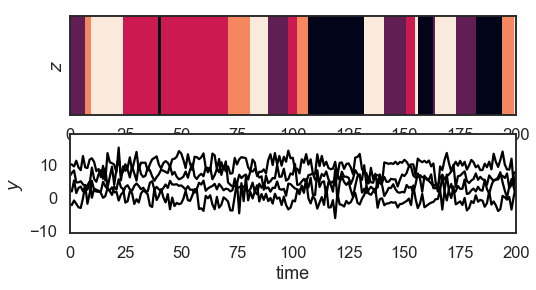

In [4]:
# Plot it
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim(0, 200)
plt.ylabel("$z$")
plt.yticks([])

plt.subplot(212)
plt.plot(y + 3 * np.arange(D), '-k')
plt.xlim(0, 200)
plt.ylabel("$y$")
# plt.yticks([])
plt.xlabel("time")

# Fit an HMM to this synthetic data

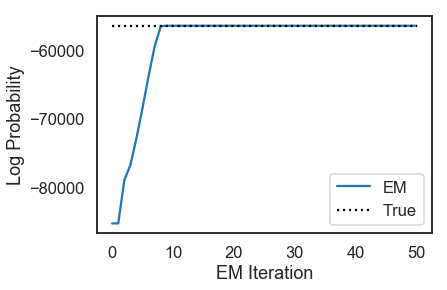

In [5]:
N_iters = 50
hmm = HMM(K, D, observations="gaussian")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters, verbose=True)

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

In [6]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))

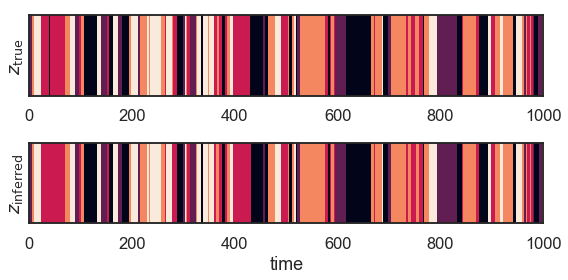

In [7]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(y)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim(0, 1000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto")
plt.xlim(0, 1000)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5,0,'time')

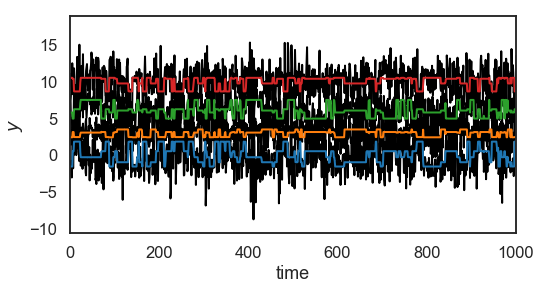

In [8]:
# Use the HMM to "smooth" the data
hmm_y = hmm.smooth(y)

plt.figure(figsize=(8, 4))
plt.plot(y + 3 * np.arange(D), '-k', lw=2)
plt.plot(hmm_y + 3 * np.arange(D), '-', lw=2)
plt.xlim(0, 1000)
plt.ylabel("$y$")
# plt.yticks([])
plt.xlabel("time")